# Analysis of anomaly detection findings
We will begin with making the necessary imports.

In [214]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import time
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from datetime import datetime

np.random.seed(48)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [25, 40]

We now read the results of running the algorithms on the merged and the complete metrics data respectively in the df and metrics dataframes.

In [215]:
df = pd.read_csv("results.csv")
metrics = pd.read_csv("results_metrics.csv")
metrics.dropna(axis=0, inplace=True)

df["timestamp"] = pd.to_datetime(df["timestamp"],unit='ms')
metrics["timestamp"] = pd.to_datetime(metrics["timestamp"],unit='ms')

We have loaded the data on which we ran the previous ML algorithms to detect outliers. These outlier predictions can be seen in the last two columns of the dataset: "anomaly" and 'anomaly_SVM'. 

A value of '1' denotes a normal data point, whereas '-1' denotes an outlier.

In [216]:
display(df.head())

,id,thread,level,timestamp,@timestamp,message,logger,POD_NAME,o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb,sli.golden.content.listing_latency,...,sli.golden.repo.mgmt_throughput,weft.ThreadPoolExecutor.galley-transfers.galley-transfers_current-load,weft.ThreadPoolExecutor.indy-event-dispatch.indy-event-dispatch_current-load,weft.ThreadPoolExecutor.koji-metadata.koji-metadata_current-load,weft.ThreadPoolExecutor.maven-metadata-generator.maven-metadata-generator_current-load,weft.ThreadPoolExecutor.promote-validation-rules-executor.promote-validation-rules-executor_current-load,weft.ThreadPoolExecutor.promote-validation-rules-runner.promote-validation-rules-runner_current-load,weft.ThreadPoolExecutor.promotion-transfers.promotion-transfers_current-load,weft.ThreadPoolExecutor.promotion.promotion_current-load,anomaly
0,AXCbFOffQp1MinEMcIGy,XNIO-2 task-10,DEBUG,2020-03-02 11:50:02.247,2020-03-02T11:50:03.299Z,Re-adding Authorization values: [],org.commonjava.indy.bind.jaxrs.keycloak.BasicA...,indy-static-58-wbm72,0.737089,75976567.0,...,1.303220e-53,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,AXCbFOffQp1MinEMcIGx,XNIO-2 task-10,DEBUG,2020-03-02 11:50:02.247,2020-03-02T11:50:03.299Z,BASIC authenticate injector checking for Autho...,org.commonjava.indy.bind.jaxrs.keycloak.BasicA...,indy-static-58-wbm72,0.737089,75976567.0,...,1.303220e-53,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,AXCbFQ-cQp1MinEMcIRM,XNIO-2 task-7,DEBUG,2020-03-02 11:50:12.247,2020-03-02T11:50:13.253Z,BASIC authenticate injector checking for Autho...,org.commonjava.indy.bind.jaxrs.keycloak.BasicA...,indy-static-58-wbm72,0.682418,75976567.0,...,1.103152e-53,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,AXCbFQ-cQp1MinEMcIRN,XNIO-2 task-7,DEBUG,2020-03-02 11:50:12.247,2020-03-02T11:50:13.253Z,Re-adding Authorization values: [],org.commonjava.indy.bind.jaxrs.keycloak.BasicA...,indy-static-58-wbm72,0.682418,75976567.0,...,1.103152e-53,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,AXCbFTV7Qp1MinEMcIjv,XNIO-2 task-16,DEBUG,2020-03-02 11:50:22.247,2020-03-02T11:50:23.252Z,Re-adding Authorization values: [],org.commonjava.indy.bind.jaxrs.keycloak.BasicA...,indy-static-58-wbm72,0.497847,75976567.0,...,9.337978e-54,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


For both dataframes we will select their anomalies for further analysis.

In [217]:
anomalies = df.loc[df["anomaly"] == -1]
print("Number of anomalies detected in the kibana log data: "+str(anomalies.shape[0]))

metrics_anomalies = metrics.loc[metrics["anomaly"]==-1]
metrics_anomalies.dropna(axis=0, inplace=True)
print("Number of anomalies detected in the metrics log data: "+str(metrics_anomalies.shape[0]))

Number of anomalies detected in the kibana log data: 93
Number of anomalies detected in the metrics log data: 209


c:\users\schub\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [218]:
errors = df.loc[df["level"]=="ERROR"]
warns = df.loc[df["level"]=="WARN"]

In [219]:
numeric_cols = df.select_dtypes(exclude=object).columns
numeric_cols = numeric_cols[1:-1] #remove columns 'timestamp' and 'anomaly'
print(numeric_cols)

Index(['o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb',
       'sli.golden.content.listing_latency',
       'sli.golden.content.listing_errors',
       'sli.golden.content.listing_throughput',
       'sli.golden.content.maven_throughput',
       'sli.golden.maven.download_latency',
       'sli.golden.maven.download_throughput',
       'sli.golden.maven.upload_latency', 'sli.golden.repo.mgmt_latency',
       'sli.golden.repo.mgmt_throughput',
       'weft.ThreadPoolExecutor.galley-transfers.galley-transfers_current-load',
       'weft.ThreadPoolExecutor.indy-event-dispatch.indy-event-dispatch_current-load',
       'weft.ThreadPoolExecutor.koji-metadata.koji-metadata_current-load',
       'weft.ThreadPoolExecutor.maven-metadata-generator.maven-metadata-generator_current-load',
       'weft.ThreadPoolExecutor.promote-validation-rules-executor.promote-validation-rules-executor_current-load',
       'weft.ThreadPoolExecutor.promote-validation-rules-runner.promote-validation-rules-runner_

## Plotting anomalies along with metric data

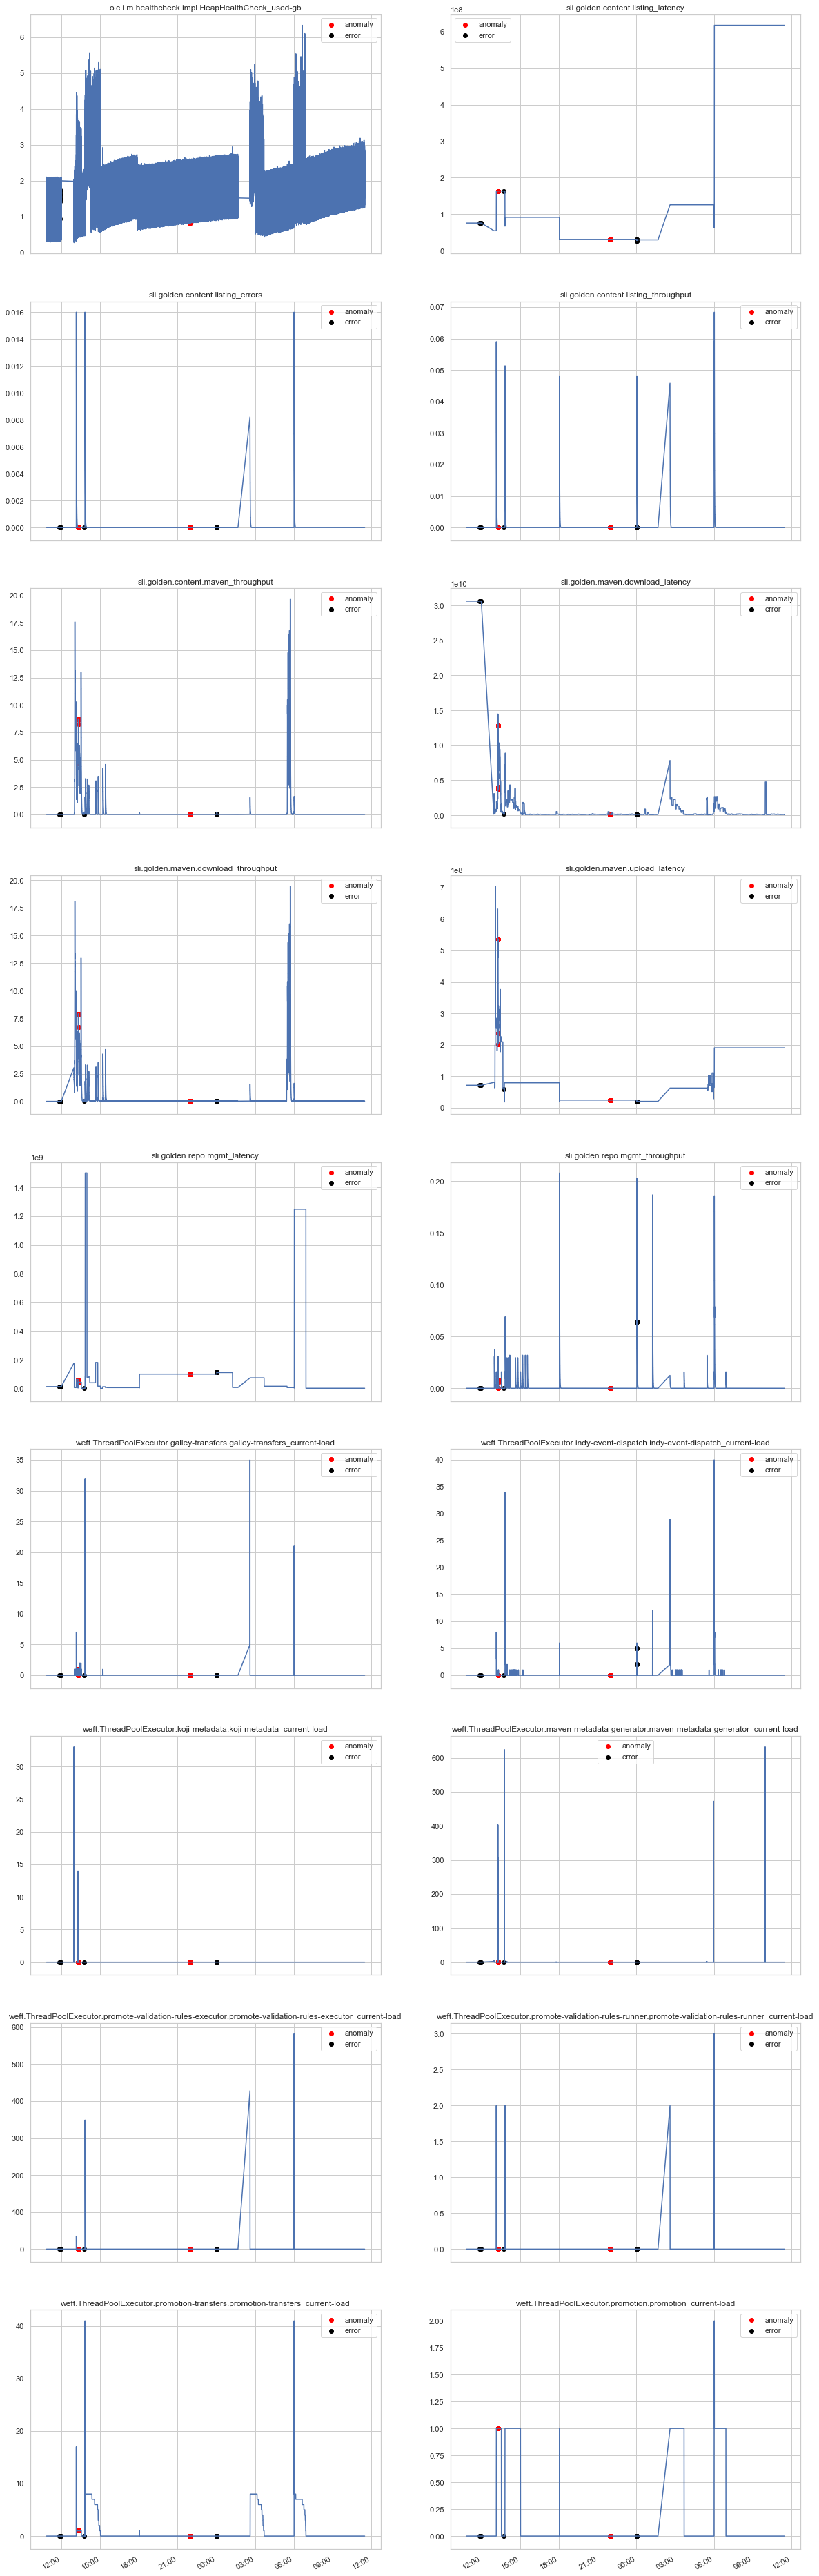

In [220]:
fig, ax = plt.subplots(9,2,figsize = (20,75), sharex=False)

for col in range(len(numeric_cols)):
    ax[col//2,col%2].plot(metrics["timestamp"],metrics[numeric_cols[col]])

    ax[col//2,col%2].scatter(anomalies["timestamp"],anomalies[numeric_cols[col]], color="red", label="anomaly")
    ax[col//2,col%2].scatter(errors["timestamp"],errors[numeric_cols[col]], color="black", label="error")
    #plt.scatter(warns["timestamp"],warns[numeric_cols[col]], color="orange", label="warning")
    
    fig.autofmt_xdate()
    #ax[col//2,col%2].tick_params(axis="x", bottom=True, labelbottom=True)
    ax[col//2,col%2].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M')) 
    ax[col//2,col%2].set_title(numeric_cols[col])
    ax[col//2,col%2].legend()
    
plt.show()

In [221]:
'''
# finding anomalies using gaussian distribution
means = df[numeric_cols].mean()
stddevs = df[numeric_cols].std()
step = 3

test = df.loc[(df[numeric_cols[0]]<(means[numeric_cols[0]]+ step * stddevs[numeric_cols[0]])) & (df[numeric_cols[0]]>(means[numeric_cols[0]] - step * stddevs[numeric_cols[0]])) ]
print(df.shape)
print(test.shape)
print("ratio: "+str(test.shape[0]/df.shape[0]))
''';

In this second we will examine a random point and how its metrics relate to the commonly seen values for the same. In our case we simply pick the 20th anomaly found and see how its' metrics differs from most observed values.

The blue region denotes the fraction of points having a value greater than that in the chosen point, and orange for those with value equal to or less than it.

In [222]:
anomaly_pt = anomalies.iloc[20] #random point from anomalies dataframe

In [223]:
above_vals = []
labels = []

for col in range(len(numeric_cols)):
    value = anomaly_pt[numeric_cols[col]]
    above = df.loc[df[numeric_cols[col]] > value].shape[0]
    above_vals.append(above)
    label = numeric_cols[col]
    labels.append(label)
    
graph_df = pd.DataFrame()
graph_df["label"] = labels
graph_df["above_vals"] = above_vals
graph_df["total"] = 38000

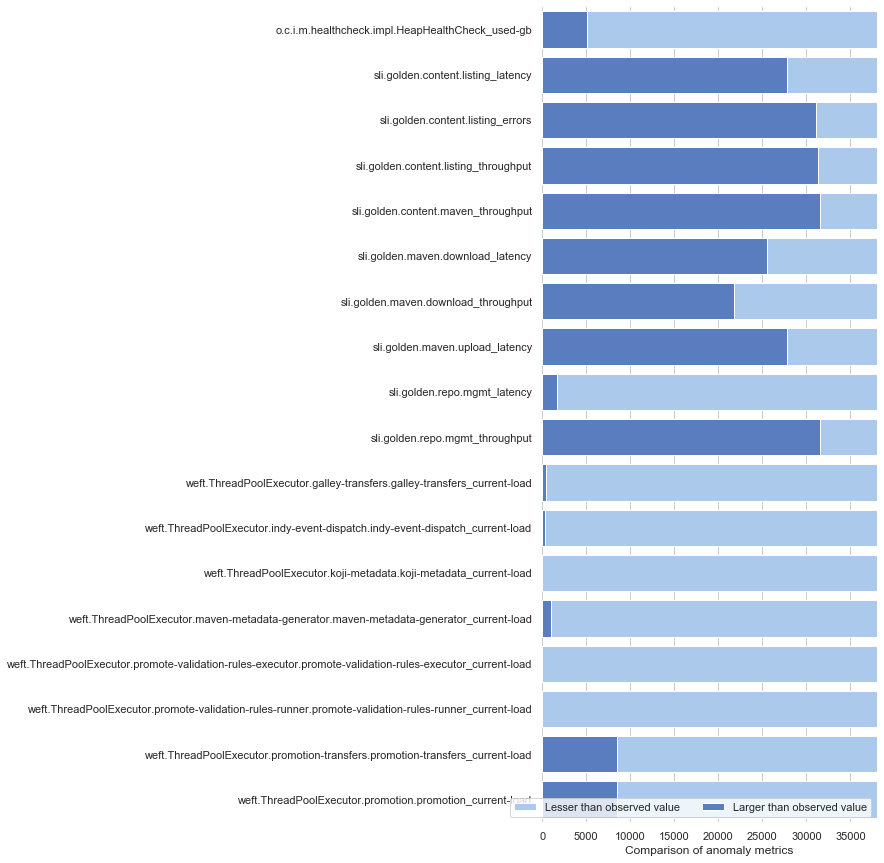

In [240]:
f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("pastel")
sns.barplot(x="total", y="label", data=graph_df, label="Lesser than observed value", color="b")

sns.set_color_codes("muted")
sns.barplot(x="above_vals", y="label", data=graph_df, label="Larger than observed value", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 38000), ylabel="", xlabel="Comparison of anomaly metrics")
sns.despine(left=True, bottom=True)

## Analysing logging rates
Here we will analyse how the rate of logging changes with respect to time.

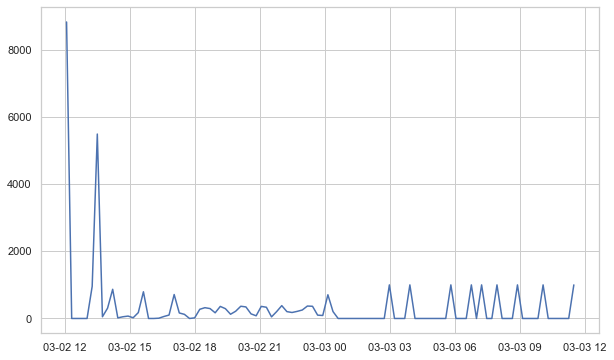

In [225]:
bins = pd.cut(df["timestamp"],100)
bin_counts = bins.value_counts(sort=False)

temp = bin_counts.keys()
temp = [i.right for i in temp]

#time_diff = df["timestamp"].iloc[-1] - df["timestamp"].iloc[0]
#x_axis = range(df["timestamp"].iloc[0],df["timestamp"].iloc[-1]-time_diff//100,time_diff//100)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(temp,bin_counts.values)
#ax.scatter(metrics_anomalies["timestamp"],metrics_anomalies[numeric_cols[col]], color="red", label="anomaly",s = 70)
#ax.scatter(errors["timestamp"],errors[numeric_cols[col]], color="black", label="error")
#ax.scatter(warns["timestamp"],warns[numeric_cols[col]], color="orange", label="warning", s=40)
#ax.legend()
plt.show()

In [226]:
temp = bin_counts.keys()
temp = [i.right for i in temp]
pd.Series(temp[:]).shape
#temp.right.hour

(100,)

In this section we will check the observed anomaly points to see whether some anomaly points are similar to one another and we do this by running a KMeans Clustering algorithm for the observed anomalies and then grouping them based on their observed clusters.

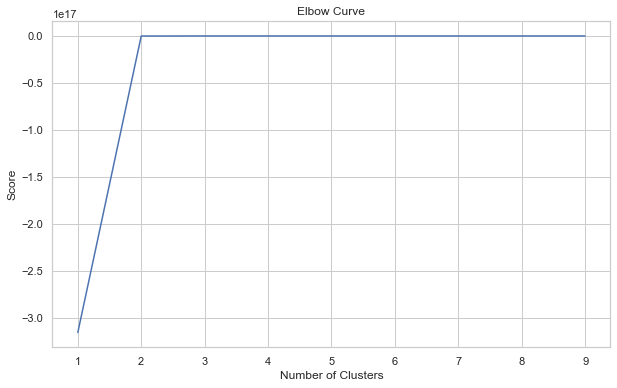

In [227]:
# Elbow curve to find the number of clusters that would be appropriate
n_cluster = range(1, 10)
kmeans = [KMeans(n_clusters=i).fit(metrics_anomalies.drop(["anomaly","timestamp"], axis = 1)) for i in n_cluster]
scores = [kmeans[i].score(metrics_anomalies.drop(["anomaly","timestamp"], axis = 1)) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

From the above curve we see how the score plateaus around the 2 mark, so we will set the number of clusters as 2.

In [228]:
model_knn_metrics = KMeans(n_clusters=2)
model_knn_metrics.fit(metrics_anomalies.drop(["anomaly","timestamp"], axis = 1))
model_knn_metrics.predict(metrics_anomalies.drop(["anomaly","timestamp"], axis = 1))
labels = model_knn_metrics.labels_

In [229]:
metrics_anomalies["anomaly_cluster"] = labels

c:\users\schub\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Graphing the different types of clusters

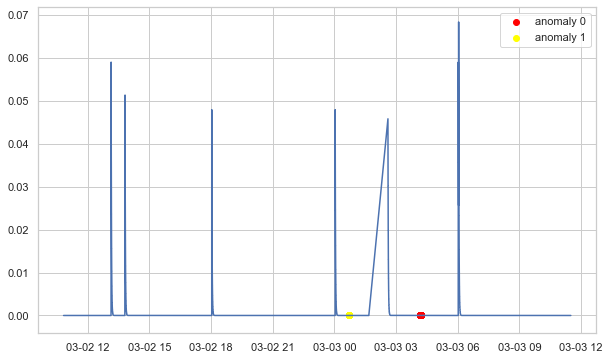

In [230]:
cluster0 = metrics_anomalies.loc[metrics_anomalies["anomaly_cluster"] == 0]
cluster1 = metrics_anomalies.loc[metrics_anomalies["anomaly_cluster"] == 1]

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(metrics["timestamp"], metrics['sli.golden.content.listing_throughput'])
ax.scatter(cluster0["timestamp"],cluster0['sli.golden.content.listing_throughput'], color="red", label="anomaly 0")
ax.scatter(cluster1["timestamp"],cluster1['sli.golden.content.listing_throughput'], color="yellow", label="anomaly 1")
#ax.scatter(warns["timestamp"],warns[numeric_cols[col]], color="orange", label="warning", s=40)
ax.legend()
plt.show()

We see that the anomalies fall into two stretches of behaviourally different anomalous operation conditions from the above graph

Taking the first cluster (cluster 0) as an example we will analyse the events occuring in the recent past of the log which might give us a better idea of the conditions under which the anomalous conditions started to occur.

In [231]:
def thread_clean(thread_type):
    thread_type = thread_type.split(" ")[0].split(":")[0]
    thread_type = re.sub("-(\d)+","",thread_type)
    return thread_type

In [232]:
cluster0_start = cluster0["timestamp"].iloc[0]
cluster0_past = df.loc[(df["timestamp"] < cluster0_start) & (df["timestamp"] > (cluster0_start - pd.Timedelta(minutes=20)))]

In [233]:
cluster0_past["message"].apply(lambda x: x.split(":")[0]).value_counts(ascending=False)

Starting delete of                                                501
Finished delete of                                                497
Re-adding Authorization values                                      1
BASIC authenticate injector checking for Authorization header.      1
Name: message, dtype: int64

In [234]:
cluster0_past["logger"].value_counts()

org.commonjava.topic.content.delete                                           998
org.commonjava.indy.bind.jaxrs.keycloak.BasicAuthenticationOAuthTranslator      2
Name: logger, dtype: int64

In [235]:
cluster0_past["message"] = cluster0_past["message"].apply(lambda x: x.split(":")[0])
cluster0_past["thread"] = cluster0_past["thread"].apply(lambda x: thread_clean(x))

c:\users\schub\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\schub\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Graphing Past Events

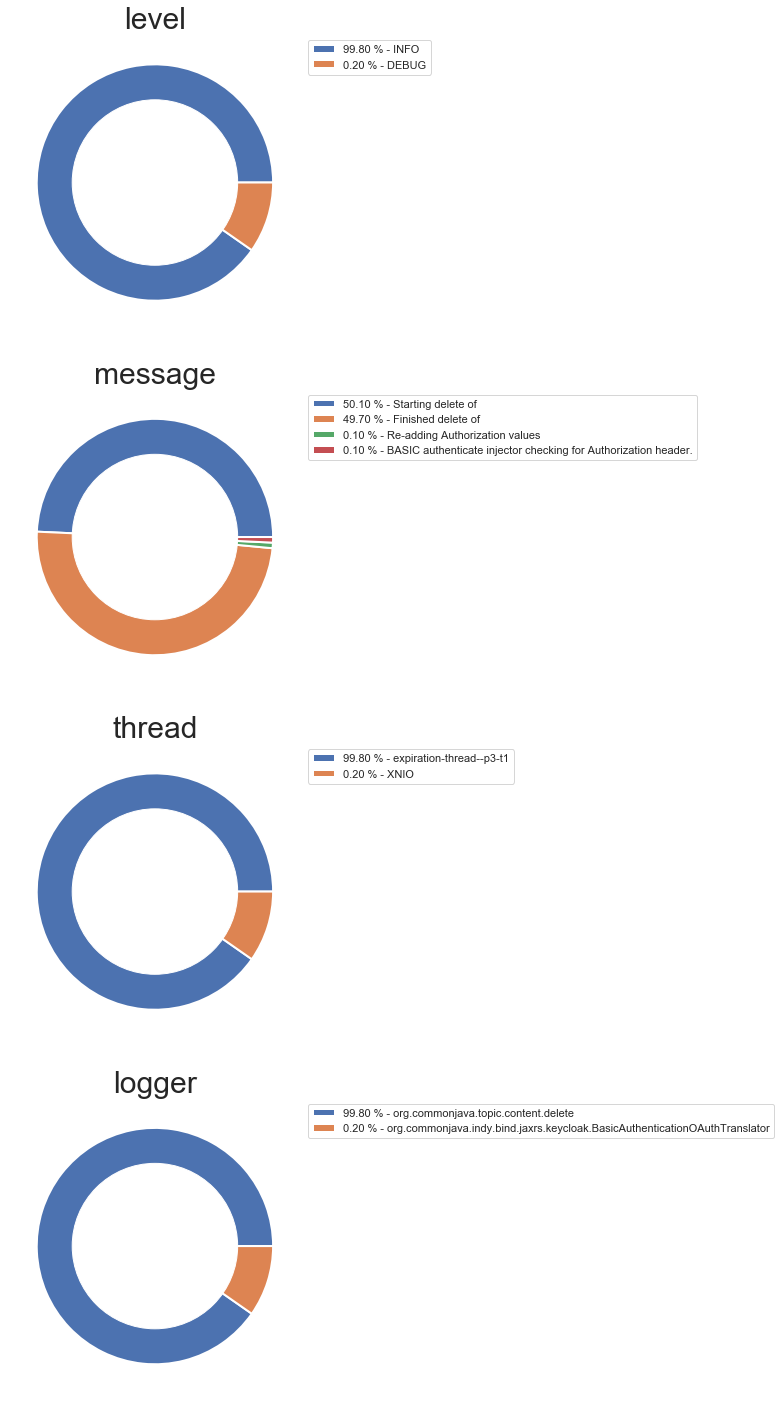

In [236]:
past_columns = ["level","message","thread","logger"]
l = []

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format

fig, ax = plt.subplots(4,1,figsize = (25,25))
for col in range(len(past_columns)):
    values = (cluster0_past[past_columns[col]].value_counts().values)
    labels = cluster0_past[past_columns[col]].value_counts().keys()
    l.append(values)
    
    #ax[col].pie(values, labels=None, autopct=autopct_format(values),textprops={'fontsize': 10},wedgeprops = {'linewidth': 2})
    ax[col].pie(np.log(values+0.1), labels=None, autopct=None,textprops={'fontsize': 10},wedgeprops = {'linewidth': 2})
    centre = plt.Circle((0, 0), 0.7, color='white')
    ax[col].add_artist(centre)
    

    ax[col].set_title(past_columns[col],fontsize=30)
    ax[col].legend(bbox_to_anchor=(1, 1), labels=['%2.2f %% - %s' % (s, l) for l, s in zip(labels, values/10)])
plt.show()
